[Open in Colab](https://colab.research.google.com/github/mizu-pumpkin/TFG2021/blob/main/sign_mnist/classifier_v3.ipynb)

# Imports

In [23]:
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

In [24]:
#Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
#import torchvision
#import torchvision.transforms as transforms
#from torchvision.transforms import ToTensor
#from torchvision.utils import make_grid
#from torchvision.datasets.utils import download_url
import matplotlib
import matplotlib.pyplot as plt

# indicates to Jupyter that we want to plot the graphs within the notebook
%matplotlib inline
# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Image Classification generic model & functions

In [25]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [26]:
@torch.no_grad()
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

# The problem-independent parts within a function called fit, which will be used
# to train the model. The problem-specific parts will be implemented by adding
# new methods to the nn.Module class.
# Configurations like batch size, learning rate, etc. (called hyperparameters),
# need to be picked in advance while training machine learning models.
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = [] # for recording epoch-wise results
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [27]:
def plot_accuracies(history):
    accuracies = [r['val_acc'] for r in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

# Utilities for moving out data & labels to the GPU, if one is available.

In [28]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

# Training an image classifier for ASL alphabet

In [29]:
#data_size = 27455
#input_size = 28*28
#output_size = 26

def int_to_char(num):
    return chr(num+65)

## Load and normalize sign-MNIST datasets

In [30]:
# Define Dataset class
class SignMnistDataset(Dataset):
    """Sign MNIST dataset."""

    def __init__(self, csv_file):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
        """
        self.raw_data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.raw_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        label = self.raw_data.iloc[idx, 0]
        label = torch.tensor(label).type(torch.LongTensor)
        
        image = self.raw_data.iloc[idx, 1:].to_numpy()
        image = torch.from_numpy(image).type(torch.FloatTensor)
        image = torch.reshape(image, (1, 28, 28))
        
        return image, label # {'label': label, 'image': image}

# Load train dataframe
dataset = SignMnistDataset('./dataset/sign_mnist_train.csv')
dataset.raw_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


Train dataset


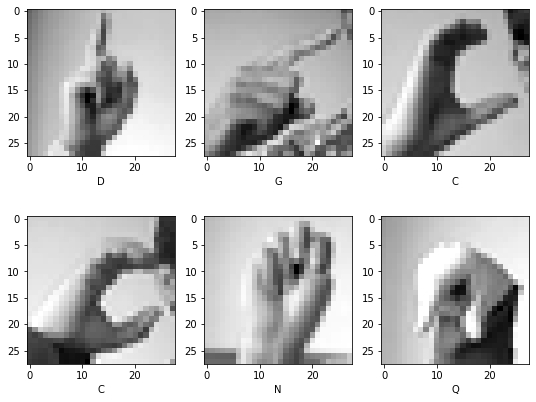

In [31]:
def plot_dataset(dataset):
    plt.figure(figsize=(9,7))
    for i in range(6):
        plt.subplot(2,3,i+1)
        image, label = dataset[i]
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.xlabel(int_to_char(label.item()))
    plt.show()

print('Train dataset')
plot_dataset(dataset)

In [32]:
# Load test dataframe
test_ds = SignMnistDataset('./dataset/sign_mnist_test.csv')
test_ds.raw_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


Test dataset


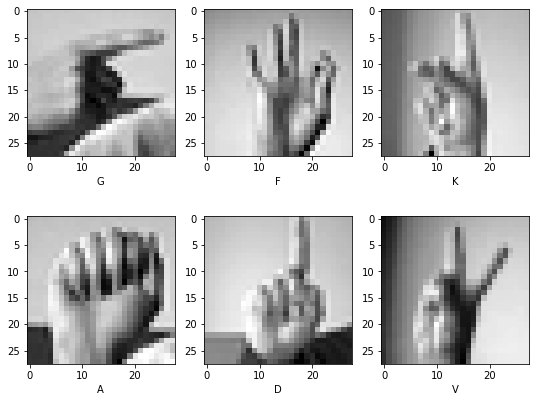

In [33]:
print('Test dataset')
plot_dataset(test_ds)

In [34]:
# Create training validation
val_size = int(len(dataset) * 0.15)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(23337, 4118)

In [35]:
# Create data loaders to load the data in batches
batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2)

In [36]:
# Move data loaders to the appropriate device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Define a Convolutional Neural Network

In [37]:
class SignMnistCNNModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # input: 1 x 28 x 28
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 14 x 14

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 7 x 7

            nn.Flatten(), 
            nn.Linear(128*7*7, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 26))
        
    def forward(self, xb):
        return self.network(xb)

## Train the network

In [38]:
# Training the model
model = SignMnistCNNModel()
to_device(model, device)

SignMnistCNNModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=6272, out_features=1024, bias=True)
    (12): ReLU()
    (13): Linear(in_features=1024, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=26, bias=True)
  )
)

In [39]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 3.356879711151123, 'val_acc': 0.033088237047195435}]

In [40]:
learning_rate = 0.01
history += fit(5, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4632, val_acc: 0.8452
Epoch [1], val_loss: 0.0098, val_acc: 0.9998
Epoch [2], val_loss: 0.0025, val_acc: 0.9998
Epoch [3], val_loss: 0.0017, val_acc: 0.9998
Epoch [4], val_loss: 0.0014, val_acc: 0.9998


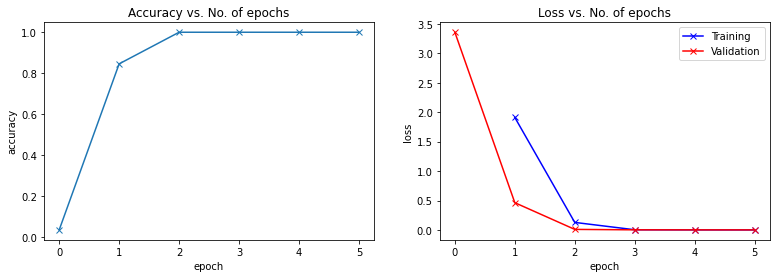

In [41]:
plt.figure(figsize=(13,4))
plt.subplot(1,2,1)
plot_accuracies(history)
plt.subplot(1,2,2)
plot_losses(history)
plt.show()

In [42]:
torch.save(model.state_dict(), './models/classifier_v3.pth')

## Test

In [43]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.3051665127277374, 'val_acc': 0.9140625}

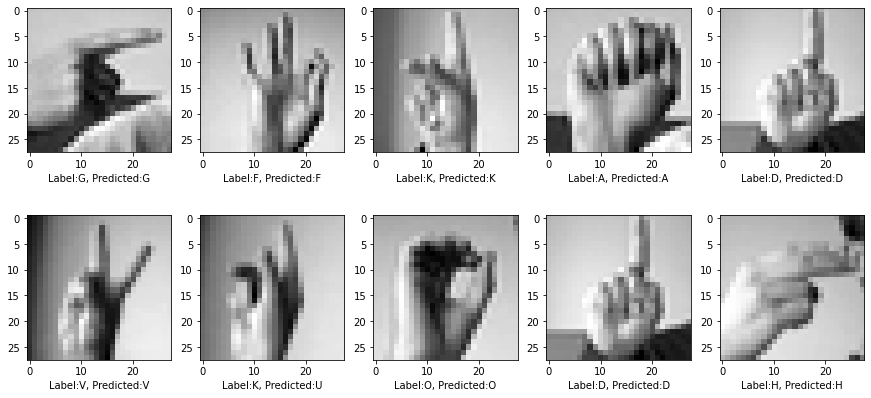

In [44]:
def predict_image(img, model):
    img = to_device(img, device)
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

def plot_prediction(dataset):
    plt.figure(figsize=(15,7))
    for i in range(10):
        plt.subplot(2,5,i+1)
        image, label = dataset[i]
        plt.imshow(image[0], cmap='gray')
        lbl = 'Label:'+int_to_char(label.item())+', Predicted:'+int_to_char(predict_image(image, model))
        plt.xlabel(lbl)
    plt.show()

plot_prediction(test_ds)